<a href="https://colab.research.google.com/github/0xmahmoudJo0/MITRE-Analysis-Prioritization/blob/main/MITRE_Proritize_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!pip install attackcti
!pip install pandas matplotlib seaborn

from pandas import *
import json

import logging
logging.getLogger('taxii2client').setLevel(logging.CRITICAL)

from attackcti import attack_client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import *
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.renderers.enable('default')

import itertools

import logging
logging.getLogger('taxii2client').setLevel(logging.CRITICAL)

Initialize AttackCTI client

In [120]:
# Initialize ATT&CK client
lift = attack_client()

# Fetch data
techniques = lift.get_techniques()
groups = lift.get_groups()
software = lift.get_software()
relationships = lift.get_relationships()
campaigns = lift.get_campaigns()

In [121]:
# Convert to DataFrames
df_techniques = pd.json_normalize([json.loads(t.serialize()) for t in techniques])
df_groups = pd.json_normalize([json.loads(g.serialize()) for g in groups])
df_software = pd.json_normalize([json.loads(s.serialize()) for s in software])
df_campaigns = pd.json_normalize([json.loads(c.serialize()) for c in campaigns])
df_relationships = pd.json_normalize([json.loads(r.serialize()) for r in relationships])

# Optionally save to CSV (for caching)
df_techniques.to_csv('all_techniques.csv', index=False)
df_groups.to_csv('all_groups.csv', index=False)
df_software.to_csv('all_software.csv', index=False)
df_campaigns.to_csv('all_relationships.csv', index=False)
df_relationships.to_csv('all_campaigns.csv', index=False)

This code filters the MITRE ATT&CK relationships DataFrame to extract specific associations for techniques (attack-patterns):
- `software_rels`: Malware/tools used in techniques.
- `group_rels`: Threat groups (intrusion sets) using techniques.
- `campaign_rels`: Campaigns linked to techniques.
- `mitigation_rels`: Mitigations (courses of action) that mitigate techniques.
- `detection_rels`: Data components detecting techniques.
Each filter selects relationships based on `relationship_type` and entity types (`source_ref`, `target_ref`), keeping only `source_ref` and `target_ref` columns.

In [122]:
# Filter relationships for specific associations:
# - Software (malware/tools) used in techniques
software_rels = df_relationships[
    (df_relationships['relationship_type'] == 'uses') &
    (df_relationships['source_ref'].str.contains('malware|tool')) &
    (df_relationships['target_ref'].str.contains('attack-pattern'))
][['source_ref', 'target_ref']]

# - Threat groups (intrusion sets) using techniques
group_rels = df_relationships[
    (df_relationships['relationship_type'] == 'uses') &
    (df_relationships['source_ref'].str.contains('intrusion-set')) &
    (df_relationships['target_ref'].str.contains('attack-pattern'))
][['source_ref', 'target_ref']]

# - Campaigns associated with techniques
campaign_rels = df_relationships[
    (df_relationships['relationship_type'] == 'uses') &
    (df_relationships['source_ref'].str.contains('campaign')) &
    (df_relationships['target_ref'].str.contains('attack-pattern'))
][['source_ref', 'target_ref']]

# - Mitigations (courses of action) mitigating techniques
mitigation_rels = df_relationships[
    (df_relationships['relationship_type'] == 'mitigates') &
    (df_relationships['source_ref'].str.contains('course-of-action')) &
    (df_relationships['target_ref'].str.contains('attack-pattern'))
][['source_ref', 'target_ref']]

# - Detections (data components) detecting techniques
detection_rels = df_relationships[
    (df_relationships['relationship_type'] == 'detects') &
    (df_relationships['source_ref'].str.contains('x-mitre-data-component')) &
    (df_relationships['target_ref'].str.contains('attack-pattern'))
][['source_ref', 'target_ref']]


This script processes MITRE ATT&CK techniques and their relationships to:
1. Aggregate linked software, threat groups, and campaigns.
2. Count mitigations and detections per technique.
3. Structure the output into a CSV with columns for:
   - Technique IDs, names, tactics, and platforms.
   - Associated malware tools (names/IDs/counts).
   - Linked threat groups and campaigns (names/IDs/counts).
   - Mitigation/detection counts.

Key Functions:
- `aggregate_rels()`: Groups relationships and maps references to names/IDs.
- Final output includes MITRE technique IDs (e.g., "T1059") and structured metadata.

Output: Saved as 'mitre_attack_techniques.csv'.
'''

In [123]:
# Define a function to aggregate relationships, extracting names, IDs, and counts
def aggregate_rels(rels, ref_col, df_ref, name_col='name', id_col='id'):
    """
    Aggregates relationships by grouping references and mapping to names, IDs, and counts.

    Parameters:
    - rels: DataFrame containing relationship data (source_ref, target_ref)
    - ref_col: Column name for the reference to aggregate (e.g., 'source_ref')
    - df_ref: Reference DataFrame containing names and IDs
    - name_col: Column name for names in df_ref
    - id_col: Column name for IDs in df_ref

    Returns:
    - DataFrame indexed by target_ref with columns for names, IDs, and count
    """
    rels_grouped = rels.groupby('target_ref')[ref_col].apply(list).reset_index()
    rels_grouped['names'] = rels_grouped[ref_col].apply(
        lambda refs: [df_ref[df_ref[id_col] == ref][name_col].iloc[0] for ref in refs if ref in df_ref[id_col].values]
    )
    rels_grouped['ids'] = rels_grouped[ref_col].apply(
        lambda refs: [ref for ref in refs if ref in df_ref[id_col].values]
    )
    rels_grouped['count'] = rels_grouped['ids'].apply(len)
    return rels_grouped.set_index('target_ref')[['names', 'ids', 'count']]

# Aggregate relationships for software, groups, and campaigns
software_agg = aggregate_rels(software_rels, 'source_ref', df_software)
group_agg = aggregate_rels(group_rels, 'source_ref', df_groups)
campaign_agg = aggregate_rels(campaign_rels, 'source_ref', df_campaigns)

# Compute counts for mitigations and detections
mitigation_counts = mitigation_rels.groupby('target_ref').size().to_dict()
detection_counts = detection_rels.groupby('target_ref').size().to_dict()

df_techniques['malware_tool_name'] = df_techniques['id'].map(software_agg['names']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['software_id'] = df_techniques['id'].map(software_agg['ids']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['software_count'] = df_techniques['id'].map(software_agg['count']).fillna(0).astype(int)
df_techniques['threat Name'] = df_techniques['id'].map(group_agg['names']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['group_id'] = df_techniques['id'].map(group_agg['ids']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['group_count'] = df_techniques['id'].map(group_agg['count']).fillna(0).astype(int)
df_techniques['campaign_name'] = df_techniques['id'].map(campaign_agg['names']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['campaign_id'] = df_techniques['id'].map(campaign_agg['ids']).apply(
    lambda x: ';'.join(x) if isinstance(x, list) else ''
)
df_techniques['campaign_count'] = df_techniques['id'].map(campaign_agg['count']).fillna(0).astype(int)
df_techniques['Mitigation Count'] = df_techniques['id'].map(mitigation_counts).fillna(0).astype(int)
df_techniques['Detection Count'] = df_techniques['id'].map(detection_counts).fillna(0).astype(int)

df_output = df_techniques[[
    'id', 'name', 'kill_chain_phases', 'external_references', 'x_mitre_platforms',
    'malware_tool_name', 'software_id', 'software_count', 'threat Name', 'group_id', 'group_count',
    'campaign_name', 'campaign_id', 'campaign_count', 'Mitigation Count', 'Detection Count'
]].copy()

# Extract technique_id from external references
df_output['technique_id'] = df_output['external_references'].apply(
    lambda refs: next((ref['external_id'] for ref in refs if ref.get('source_name') == 'mitre-attack'), None)
)

# Extract tactics from kill_chain_phases
df_output['tactic'] = df_output['kill_chain_phases'].apply(
    lambda phases: [phase['phase_name'] for phase in phases] if isinstance(phases, list) else []
)

# Convert list columns to string representations for CSV compatibility
df_output['tactic'] = df_output['tactic'].apply(str)
df_output['x_mitre_platforms'] = df_output['x_mitre_platforms'].apply(str)

# Define final columns for output
final_columns = [
    'id', 'technique_id', 'name', 'tactic', 'x_mitre_platforms', 'malware_tool_name', 'software_id',
    'software_count', 'threat Name', 'group_id', 'group_count', 'campaign_name', 'campaign_id', 'campaign_count',
    'Mitigation Count', 'Detection Count'
]
df_output = df_output[final_columns]

df_output.to_csv('mitre_attack_techniques.csv', index=False)

In [124]:
df_mitre_all_platforms = pd.read_csv('mitre_attack_techniques.csv')

In [125]:
# Filter techniques applicable to Windows (proxy for AD relevance)
df_analysis = df_mitre_all_platforms[df_techniques['x_mitre_platforms'].apply(lambda x: 'Windows' in x if isinstance(x, list) else False)].copy()

In [176]:
df_analysis.to_csv('mitre_attack_techniques_windows.csv', index=False)

In [126]:
df_analysis.head()

,id,technique_id,name,tactic,x_mitre_platforms,malware_tool_name,software_id,software_count,threat Name,group_id,group_count,campaign_name,campaign_id,campaign_count,Mitigation Count,Detection Count
0,attack-pattern--0af0ca99-357d-4ba1-805f-674fdf...,T1561.002,Disk Structure Wipe,['impact'],"['Linux', 'macOS', 'Windows', 'Network']",Shamoon;BFG Agonizer;HermeticWiper;RawDisk;Whi...,malware--8901ac23-6b50-410c-b0dd-d8174a86f9b3;...,11,Lazarus Group;APT38;Sandworm Team;APT37;Ember ...,intrusion-set--c93fccb1-e8e8-42cf-ae33-2ad1d18...,5,HomeLand Justice,campaign--7e21077d-2589-43a7-a5f9-490061289526,1,1,5
3,attack-pattern--09a60ea3-a8d1-4ae5-976e-578324...,T1056.001,Keylogging,"['collection', 'credential-access']","['Windows', 'macOS', 'Linux', 'Network']",Empire;EvilGrab;XAgentOSX;Prikormka;Fysbis;Mic...,tool--3433a9e8-1c47-4320-b9bf-ed449061d1c3;mal...,116,APT38;Magic Hound;APT39;APT28;Ajax Security Te...,intrusion-set--00f67a77-86a4-4adf-be26-1a54fc7...,25,Operation Wocao;2015 Ukraine Electric Power At...,campaign--b03d5112-e23a-4ac8-add0-be7502d24eff...,3,0,3
4,attack-pattern--09b008a9-b4eb-462a-a751-a0eb58...,T1564.012,File/Path Exclusions,['defense-evasion'],"['Linux', 'macOS', 'Windows']",NaN,NaN,0,Turla,intrusion-set--7a19ecb1-3c65-4de3-a230-993516a...,1,NaN,NaN,0,2,1
6,attack-pattern--09c4c11e-4fa1-4f8c-8dad-3cf8e6...,T1110.001,Password Guessing,['credential-access'],"['Windows', 'SaaS', 'IaaS', 'Linux', 'macOS', ...",China Chopper;Emotet;SpeakUp;HermeticWizard;Cr...,malware--5a3a31fe-5a8f-48e1-bff0-a753e5b1be70;...,9,APT28;APT29,intrusion-set--bef4c620-0787-42a8-a96d-b7eb6e8...,2,NaN,NaN,0,4,2
7,attack-pattern--09cd431f-eaf4-4d2a-acaf-2a7acf...,T1216.001,PubPrn,['defense-evasion'],['Windows'],NaN,NaN,0,APT32,intrusion-set--247cb30b-955f-42eb-97a5-a89fef6...,1,NaN,NaN,0,2,3


The following section analyzes relationships between ATT&CK techniques and:
1. Software Tools: Maps malware/tools to techniques and counts usage.
2. Threat Groups: Identifies intrusion-sets (APT groups) using each technique.
3. Tactics: Computes frequency of techniques per ATT&CK tactic.
4. Campaigns: Counts techniques linked to  campaigns.

In [127]:
import pandas as pd
import ast
from collections import defaultdict
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create a mapping for software used by techniques using relationships
technique_software_map = defaultdict(list)
for _, row in df_relationships.iterrows():
    if row['relationship_type'] == 'uses' and row['source_ref'].startswith(('malware--', 'tool--')):
        technique_software_map[row['target_ref']].append(row['source_ref'])

# Add malware_tool_name to df_analysis based on software IDs
df_analysis['malware_tool_name'] = df_analysis['id'].map(
    lambda x: ';'.join(technique_software_map.get(x, []))
)

# Analysis 1: Compute counts of software tools per technique
software_counts = defaultdict(int)
for _, row in df_analysis.iterrows():
    if row['malware_tool_name']:
        tools = [t.strip() for t in row['malware_tool_name'].split(';') if t.strip()]
        software_counts[(row['technique_id'], row['name'])] = len(tools)
sorted_software = sorted(software_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Analysis 2: Compute counts of threat groups per technique
technique_group_map = defaultdict(list)
for _, row in df_relationships.iterrows():
    if row['relationship_type'] == 'uses' and row['source_ref'].startswith('intrusion-set--'):
        technique_group_map[row['target_ref']].append(row['source_ref'])

# Use group_count from df_analysis directly (computed earlier)
group_counts = defaultdict(int)
for _, row in df_analysis.iterrows():
    group_counts[(row['technique_id'], row['name'])] = row['group_count']
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Analysis 3: Compute frequency of tactics
tactic_counts = defaultdict(int)
for _, row in df_analysis.iterrows():
    if row['tactic']:
        # Parse tactic column (stored as string representation of a list)
        tactics = ast.literal_eval(row['tactic']) if isinstance(row['tactic'], str) else row['tactic']
        for tactic in tactics:
            tactic_counts[tactic] += 1
sorted_tactics = sorted(tactic_counts.items(), key=lambda x: x[1], reverse=True)

# Analysis 4: Compute counts of campaigns per technique
# Use campaign_count from df_analysis directly (computed earlier)
campaign_counts = defaultdict(int)
for _, row in df_analysis.iterrows():
    campaign_counts[(row['technique_id'], row['name'])] = row['campaign_count']
sorted_campaigns = sorted(campaign_counts.items(), key=lambda x: x[1], reverse=True)[:20]

In [164]:
def plot_top_items(items, title, ylabel, filename,
                   figsize=(8, 4), bar_color='#1f77b4', bar_width=0.7,
                   title_fontsize=12, label_fontsize=10, tick_fontsize=9,
                   value_fontsize=8, xrotation=45, ymax_pad=0.1,
                   bar_spacing=0.2, value_label_offset=0.3, show_values=True):
    """
    Generates a vertical bar plot for techniques or similar data and saves it as PNG.

    Parameters:
    - items: List of ((technique_id, name), count) tuples
    - title: Plot title
    - ylabel: Y-axis label
    - filename: Output PNG filename
    - Other parameters control plot aesthetics
    """
    plt.figure(figsize=figsize)
    labels = [item[0][0] for item in items]
    counts = [item[1] for item in items]
    ax = sns.barplot(x=labels, y=counts, color=bar_color,
                     width=bar_width, linewidth=0.5)
    plt.ylim(0, max(counts) * (1 + ymax_pad))
    plt.margins(x=bar_spacing)
    plt.title(title, fontsize=title_fontsize, pad=15)
    plt.xlabel('Technique ID', fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(rotation=xrotation, ha='right', fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    if show_values:
        for i, count in enumerate(counts):
            ax.text(i, count + value_label_offset, str(count),
                    ha='center', va='bottom',
                    fontsize=value_fontsize, color='black')
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

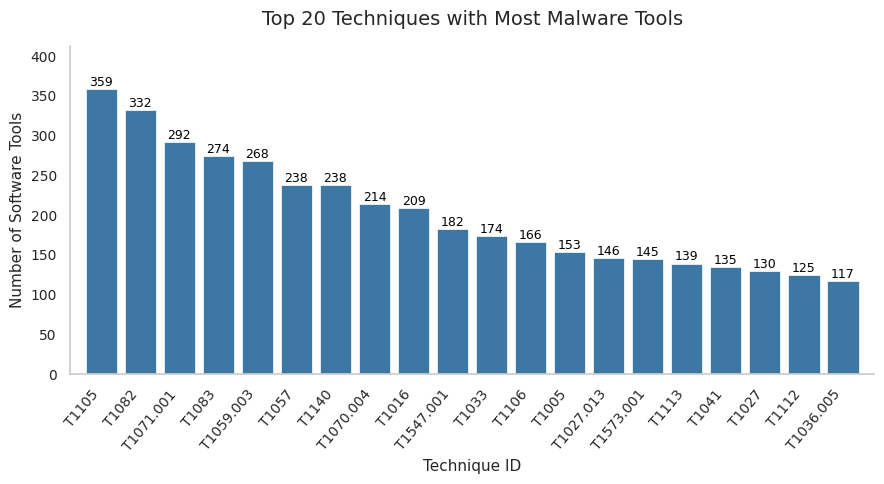

In [165]:
# Plot Analysis 1: Top 20 Techniques by Software Used
plot_top_items(
    sorted_software,
    title='Top 20 Techniques with Most Malware Tools',
    ylabel='Number of Software Tools',
    filename='top_techniques_software.png',
    figsize=(9, 5),
    bar_color='#2c7bb6',
    bar_width=0.8,
    title_fontsize=14,
    label_fontsize=11,
    tick_fontsize=10,
    value_fontsize=9,
    xrotation=50,
    ymax_pad=0.15,
    bar_spacing=0.02,
    value_label_offset=0.2
)

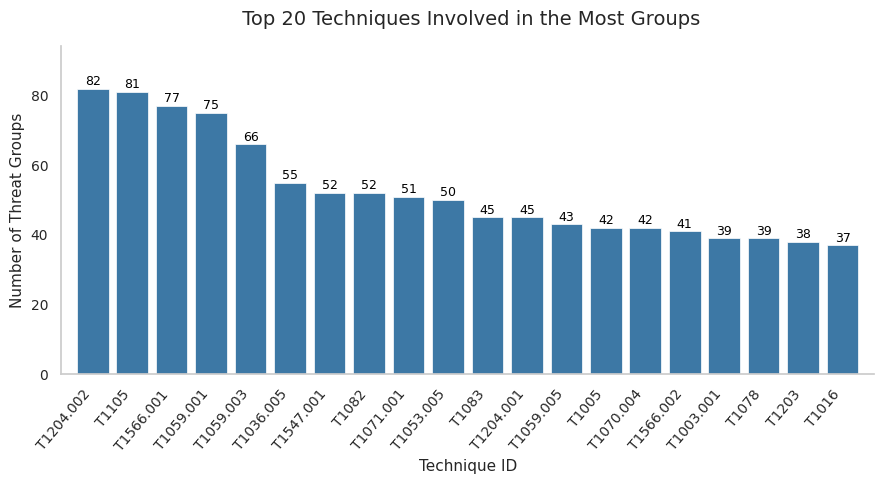

In [174]:
# Plot Analysis 2: Top 20 Techniques by Threat Groups
plot_top_items(
    sorted_groups,
    title=' Top 20 Techniques Involved in the Most Groups',
    ylabel='Number of Threat Groups',
    filename='top_techniques_groups.png',
    figsize=(9, 5),
    bar_color='#2c7bb6',
    bar_width=0.8,
    title_fontsize=14,
    label_fontsize=11,
    tick_fontsize=10,
    value_fontsize=9,
    xrotation=50,
    ymax_pad=0.15,
    bar_spacing=0.02,
    value_label_offset=0.2
)


Top 20 Techniques by Campaigns:


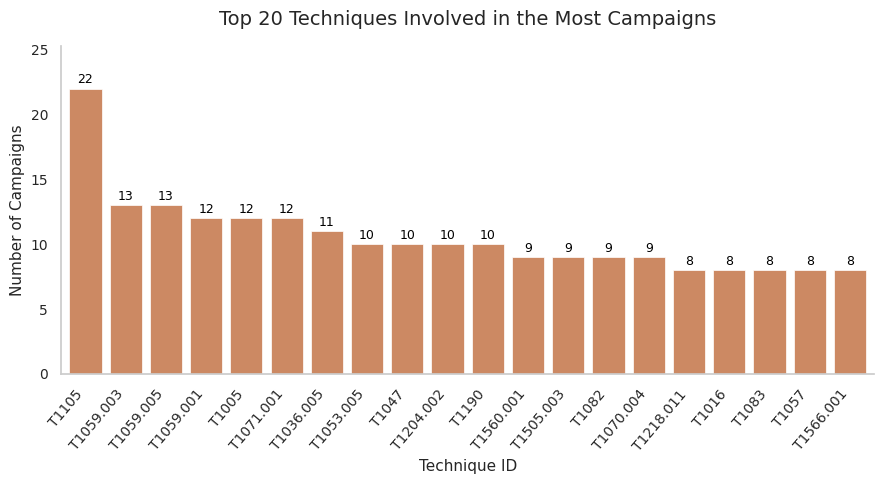

In [167]:
print("\nTop 20 Techniques by Campaigns:")
plot_top_items(
    sorted_campaigns,
    title='Top 20 Techniques Involved in the Most Campaigns',
    filename='top_techniques_campaigns.png',
    ylabel='Number of Campaigns',
    figsize=(9, 5),
    bar_color='#dd8452',
    bar_width=0.8,
    title_fontsize=14,
    label_fontsize=11,
    tick_fontsize=10,
    value_fontsize=9,
    xrotation=50,
    ymax_pad=0.15,
    bar_spacing=0.01,
    value_label_offset=0.2
)

In [169]:
def plot_stacked_groups_campaigns(group_data, campaign_data, top_n, filename,
                                  figsize=(12, 8), group_color='#1f77b4',
                                  campaign_color='#ff7f0e'):
    """
    Generates a stacked bar chart for threat groups and campaigns, saved as PNG.

    Parameters:
    - group_data: List of ((technique_id, name), count) tuples for groups
    - campaign_data: List of ((technique_id, name), count) tuples for campaigns
    - top_n: Number of top techniques to display
    - filename: Output PNG filename
    - Other parameters control plot aesthetics
    """
    combined = defaultdict(lambda: {'groups': 0, 'campaigns': 0})
    for (tech_id, tech_name), count in group_data:
        combined[(tech_id, tech_name)]['groups'] = count
    for (tech_id, tech_name), count in campaign_data:
        combined[(tech_id, tech_name)]['campaigns'] = count
    sorted_combined = sorted(
        combined.items(),
        key=lambda x: (x[1]['groups'] + x[1]['campaigns']),
        reverse=True
    )[:top_n]
    techniques = [f"{tech[0][0]}" for tech in sorted_combined]
    groups = [tech[1]['groups'] for tech in sorted_combined]
    campaigns = [tech[1]['campaigns'] for tech in sorted_combined]
    plt.figure(figsize=figsize)
    plt.bar(techniques, groups, color=group_color, label='Threat Groups')
    plt.bar(techniques, campaigns, bottom=groups, color=campaign_color, label='Campaigns')
    plt.title(f'Top {top_n} Techniques by Threat Groups and Campaigns', fontsize=14)
    plt.xlabel('Technique ID', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    for i, (g, c) in enumerate(zip(groups, campaigns)):
        total = g + c
        plt.text(i, total + 0.5, str(total),
                 ha='center', va='bottom',
                 fontsize=9, color='black')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

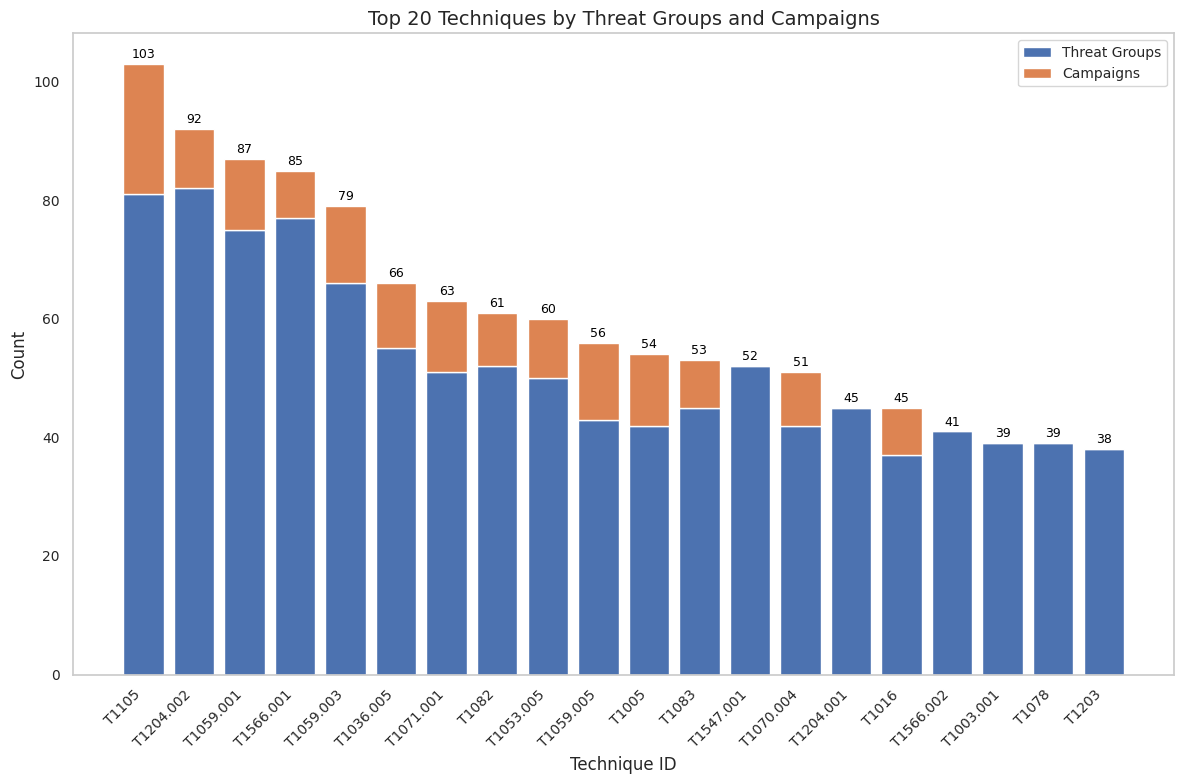

In [168]:
# Plot Combined Threat Groups and Campaigns
plot_stacked_groups_campaigns(
    sorted_groups,
    sorted_campaigns,
    top_n=20,
    filename='stacked_groups_campaigns.png',
    figsize=(12, 8),
    group_color='#4c72b0',
    campaign_color='#dd8452'
)


In [170]:
def plot_top_tactics(items, title, ylabel, filename,
                     figsize=(8, 4), bar_color='#1f77b4', bar_width=0.7,
                     title_fontsize=12, label_fontsize=10, tick_fontsize=9,
                     value_fontsize=8, xrotation=45, ymax_pad=0.1,
                     bar_spacing=0.2, value_label_offset=0.3, show_values=True):
    """
    Generates a vertical bar plot for tactics and saves it as PNG.

    Parameters:
    - items: List of (tactic, count) tuples
    - title: Plot title
    - ylabel: Y-axis label
    - filename: Output PNG filename
    - Other parameters control plot aesthetics
    """
    plt.figure(figsize=figsize)
    tactics = [item[0] for item in items]
    counts = [item[1] for item in items]
    ax = sns.barplot(x=tactics, y=counts, color=bar_color,
                     width=bar_width, linewidth=0.5)
    plt.ylim(0, max(counts) * (1 + ymax_pad))
    plt.margins(x=bar_spacing)
    plt.title(title, fontsize=title_fontsize, pad=15)
    plt.xlabel('Tactic', fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(rotation=xrotation, ha='right', fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    if show_values:
        for i, count in enumerate(counts):
            ax.text(i, count + value_label_offset, str(count),
                    ha='center', va='bottom',
                    fontsize=value_fontsize, color='black')
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()



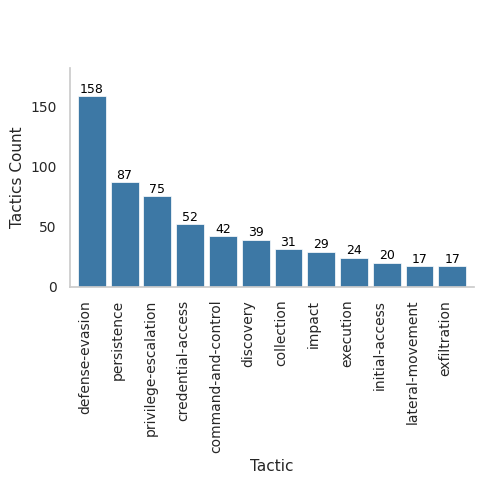

In [173]:
# Plot Analysis 3: Tactics Distribution
plot_top_tactics(
    sorted_tactics,
    title='\n',
    ylabel='Tactics Count',
    filename='tactics_distribution.png',
    figsize=(5, 5),
    bar_color='#2c7bb6',
    bar_width=0.85,
    title_fontsize=14,
    label_fontsize=11,
    tick_fontsize=10,
    value_fontsize=9,
    xrotation=90,
    ymax_pad=0.15,
    bar_spacing=0.02,
    value_label_offset=0.2
)



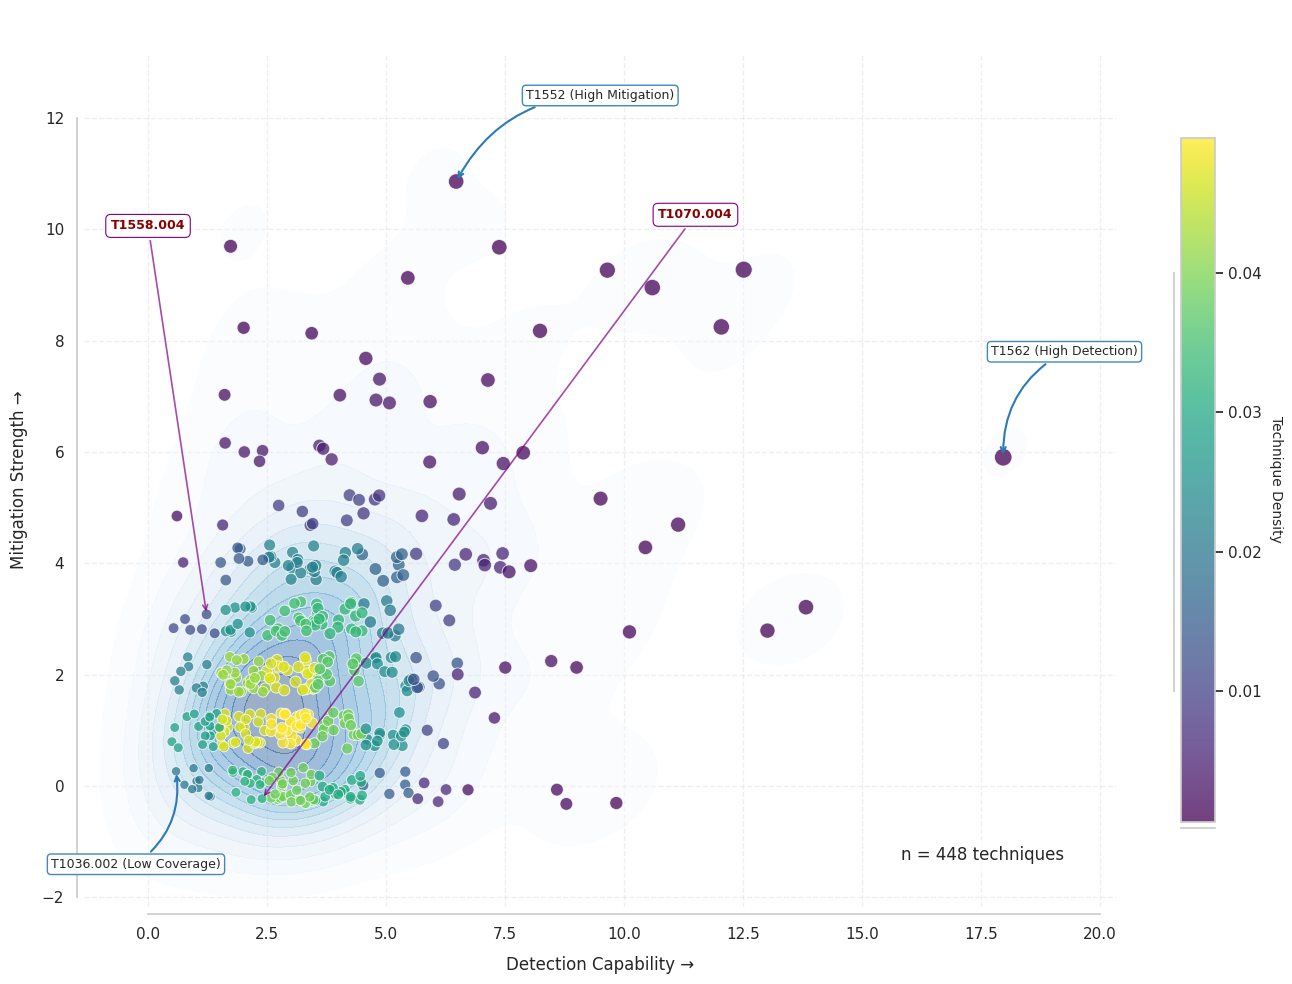

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

SEED = 42
JITTER_PCT = 0.03
DPI = 300
FIG_SIZE = (14, 10)
COLOR_MAP = 'viridis'
OUTPUT_FORMATS = ['pdf', 'png']

TECHNIQUES_TO_HIGHLIGHT = ['T1558.004', 'T1070.004']  # Add/remove technique IDs here
HIGHLIGHT_STYLE = {
    'color': 'darkred',
    'fontsize': 9,
    'fontweight': 'bold',
    'arrow_color': 'purple',
    'offsets': [(0, 10), (11.5, 10.2)] if len(TECHNIQUES_TO_HIGHLIGHT) > 1 else [(0, 10)],
    'bbox_style': dict(boxstyle="round,pad=0.4", fc="white", ec="purple", lw=0.8)
}

def load_data_from_df(df_analysis) -> Tuple[List[Dict], List[float], List[float], List[str]]:
    techniques = []
    mitigations = []
    detections = []
    labels = []

    required_columns = {'technique_id', 'name', 'Mitigation Count', 'Detection Count'}

    # Check if all required columns are present in the DataFrame
    if not required_columns.issubset(df_analysis.columns):
        missing = required_columns - set(df_analysis.columns)
        raise ValueError(f"Missing required columns in DataFrame: {missing}")

    for row_num, row in df_analysis.iterrows():
        try:
            mit = int(row['Mitigation Count'])
            det = int(row['Detection Count'])
            tech_id = row['technique_id'].strip()
            name = row['name'].strip()

            techniques.append({
                'id': tech_id,
                'name': name,
                'mitigation': mit,
                'detection': det
            })
            mitigations.append(mit)
            detections.append(det)
            labels.append(f"{tech_id}\n{name}")
        except (ValueError, KeyError, TypeError) as e:
            print(f"Skipping row {row_num}: Invalid data - {str(e)}")
            continue

    if not techniques:
        raise ValueError("No valid data extracted from DataFrame.")

    return techniques, detections, mitigations, labels

def calculate_statistics(detections: List[float], mitigations: List[float]) -> Dict:
    stats = {
        'pearson_r': pearsonr(detections, mitigations)[0],
        'corr_p': pearsonr(detections, mitigations)[1],
        'detection_range': np.ptp(detections),
        'mitigation_range': np.ptp(mitigations),
        'n': len(detections)
    }
    return stats

def generate_visualization(techniques: List[Dict],
                           detections: List[float],
                           mitigations: List[float],
                           stats: Dict) -> plt.Figure:
    np.random.seed(SEED)

    # Density estimation
    xy = np.vstack([detections, mitigations])
    z = gaussian_kde(xy)(xy)

    # Adaptive jitter based on data ranges (dynamic jitter)
    jitter = [
        stats['detection_range'] * JITTER_PCT,
        stats['mitigation_range'] * JITTER_PCT
    ]
    detections_jitter = np.array(detections) + np.random.uniform(-jitter[0], jitter[0], len(detections))
    mitigations_jitter = np.array(mitigations) + np.random.uniform(-jitter[1], jitter[1], len(mitigations))

    # Figure setup
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # KDE Plot (heatmap base)
    sns.kdeplot(
        x=detections,
        y=mitigations,
        cmap="Blues",
        fill=True,
        thresh=0.02,
        alpha=0.4,
        levels=15,
        ax=ax
    )

    # Scatter plot with density-based coloring using jittered data
    scatter = ax.scatter(
        detections_jitter,
        mitigations_jitter,
        c=z,
        s=40 + (np.array(mitigations) + np.array(detections)) * 5,
        edgecolor='w',
        linewidth=0.7,
        cmap=COLOR_MAP,
        alpha=0.75,
        zorder=2
    )

    # Statistical annotation (placed in the lower-right margin)
    stats_text = (f"n = {stats['n']} techniques")
    ax.text(0.95, 0.05, stats_text,
            transform=ax.transAxes,
            ha='right', va='bottom',
            bbox=dict(facecolor='white', alpha=0.8))

    # Define key techniques for annotation
    key_techniques = {
        'Low Coverage': min(techniques, key=lambda x: x['detection'] + x['mitigation']),
        'High Mitigation': max(techniques, key=lambda x: x['mitigation']),
        'High Detection': max(techniques, key=lambda x: x['detection'])
    }

    # Fixed annotation positions (axes fraction coordinates) for margin-based labels
    annotation_positions = {
        'Low Coverage': (0.05, 0.05),        # Bottom-left corner of the axes
        'High Mitigation': (0.5, 0.95),       # Top-left corner
        'High Detection': (0.95, 0.65)         # Top-right corner
    }

    # Annotate key techniques using margin positions
    for label, tech in key_techniques.items():
        idx = next(i for i, t in enumerate(techniques) if t['id'] == tech['id'])
        # Data coordinates for the point (with jitter)
        x_data = detections_jitter[idx]
        y_data = mitigations_jitter[idx]
        # Designated annotation position in axes fraction coordinates
        ann_pos = annotation_positions[label]
        ax.annotate(
            f"{tech['id']} ({label})",
            xy=(x_data, y_data),
            xycoords='data',
            xytext=ann_pos,
            textcoords='axes fraction',
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle="arc3,rad=.3",
                color='#2c7bb6',
                linewidth=1.5
            ),
            bbox=dict(
                boxstyle="round,pad=0.3",
                fc="white",
                ec="#2c7bb6",
                alpha=0.9
            ),
            fontsize=9,
            ha='center',
            va='center'
        )

    # Highlight specified techniques
    for i, highlight_id in enumerate(TECHNIQUES_TO_HIGHLIGHT):
        tech = next((t for t in techniques if t['id'] == highlight_id), None)
        if tech is not None:
            idx = techniques.index(tech)
            x = detections_jitter[idx]
            y = mitigations_jitter[idx]
            offset = HIGHLIGHT_STYLE['offsets'][i % len(HIGHLIGHT_STYLE['offsets'])]
            ax.annotate(
                tech['id'],
                xy=(x, y),
                xytext=offset,
                arrowprops=dict(
                    arrowstyle="->",
                    color=HIGHLIGHT_STYLE['arrow_color'],
                    lw=1.2,
                    alpha=0.7
                ),
                bbox=HIGHLIGHT_STYLE['bbox_style'],
                ha='center',
                fontsize=HIGHLIGHT_STYLE['fontsize'],
                color=HIGHLIGHT_STYLE['color'],
                fontweight=HIGHLIGHT_STYLE['fontweight']
            )

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Technique Density', rotation=270, labelpad=15, fontsize=10)

    ax.set_title("  ", fontsize=14, pad=20, weight='semibold')
    ax.set_xlabel("Detection Capability →", fontsize=12, labelpad=10)
    ax.set_ylabel("Mitigation Strength →", fontsize=12, labelpad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    sns.despine(offset=5, trim=True)

    plt.tight_layout()
    return fig

def main():
    """Main execution flow."""
    techniques, detections, mitigations, _ = load_data_from_df(df_analysis)

    stats = calculate_statistics(detections, mitigations)

    fig = generate_visualization(techniques, detections, mitigations, stats)

    base_name = 'technique_coverage_analysis'
    for fmt in OUTPUT_FORMATS:
        fig.savefig(f"{base_name}.{fmt}", format=fmt, bbox_inches='tight', dpi=DPI)


if __name__ == "__main__":
    main()

get a clear DF for APT3 techniques, that has been done by grepping the `intrusion-set` os the APT3 group from `group_id` coulmn

In [133]:
apt3_filtered_df = df_analysis[df_analysis['group_id'].str.contains("intrusion-set--0bbdf25b-30ff-4894-a1cd-49260d0dd2d9", na=False)]

In [134]:
apt3_filtered_df.head()

,id,technique_id,name,tactic,x_mitre_platforms,malware_tool_name,software_id,software_count,threat Name,group_id,group_count,campaign_name,campaign_id,campaign_count,Mitigation Count,Detection Count
3,attack-pattern--09a60ea3-a8d1-4ae5-976e-578324...,T1056.001,Keylogging,"['collection', 'credential-access']","['Windows', 'macOS', 'Linux', 'Network']",tool--3433a9e8-1c47-4320-b9bf-ed449061d1c3;mal...,tool--3433a9e8-1c47-4320-b9bf-ed449061d1c3;mal...,116,APT38;Magic Hound;APT39;APT28;Ajax Security Te...,intrusion-set--00f67a77-86a4-4adf-be26-1a54fc7...,25,Operation Wocao;2015 Ukraine Electric Power At...,campaign--b03d5112-e23a-4ac8-add0-be7502d24eff...,3,0,3
23,attack-pattern--005a06c6-14bf-4118-afa0-ebcd8a...,T1053.005,Scheduled Task,"['execution', 'persistence', 'privilege-escala...",['Windows'],malware--5c747acd-47f0-4c5a-b9e5-213541fc01e0;...,malware--5c747acd-47f0-4c5a-b9e5-213541fc01e0;...,101,Cobalt Group;APT3;Sandworm Team;HEXANE;Magic H...,intrusion-set--dc6fe6ee-04c2-49be-ba3d-f38d246...,50,SolarWinds Compromise;2022 Ukraine Electric Po...,campaign--808d6b30-df4e-4341-8248-724da4bac650...,10,4,7
25,attack-pattern--00f90846-cbd1-4fc5-9233-df5c2b...,T1560.001,Archive via Utility,['collection'],"['Linux', 'macOS', 'Windows']",malware--925a6c52-5cf0-4fec-99de-b0d6917d8593;...,malware--925a6c52-5cf0-4fec-99de-b0d6917d8593;...,25,Wizard Spider;menuPass;HAFNIUM;CopyKittens;Fox...,intrusion-set--dd2d9ca6-505b-4860-a604-233685b...,34,Operation CuckooBees;FunnyDream;Operation Woca...,campaign--93c23946-49af-41f4-ac03-40f9ffc7419b...,9,1,3
31,attack-pattern--03d7999c-1f4c-42cc-8373-e7690d...,T1033,System Owner/User Discovery,['discovery'],"['Linux', 'macOS', 'Windows', 'Network']",malware--bdb27a1d-1844-42f1-a0c0-826027ae0326;...,malware--bdb27a1d-1844-42f1-a0c0-826027ae0326;...,174,Ke3chang;FIN8;APT38;Moonstone Sleet;Winter Viv...,intrusion-set--6713ab67-e25b-49cc-808d-2b36d4f...,36,C0017;Operation Wocao;Operation CuckooBees;Nig...,campaign--ba6dfa37-f401-4140-88b0-8938f2895e61...,6,0,9
37,attack-pattern--045d0922-2310-4e60-b5e4-330230...,T1218.011,Rundll32,['defense-evasion'],['Windows'],malware--79499993-a8d6-45eb-b343-bf58dea5bdde;...,malware--79499993-a8d6-45eb-b343-bf58dea5bdde;...,66,Gamaredon Group;FIN7;APT19;APT32;Wizard Spider...,intrusion-set--2e290bfe-93b5-48ce-97d6-edcd6d3...,24,Operation Dream Job;C0021;C0015;Operation Spal...,campaign--0257b35b-93ef-4a70-80dd-ad5258e6045b...,8,1,4


In [135]:
apt3_filtered_df.to_csv('mitre_apt3_filtered.csv', index=False)

In [136]:
import pandas as pd
import numpy as np
import logging
import uuid

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Function to calculate Entropy Weight Method
def entropy_weight_method(df, criteria):
    # Normalize the decision matrix
    p_ij = df[criteria].div(df[criteria].sum(axis=0), axis=1)
    # Replace 0 with small value to avoid log(0)
    p_ij = p_ij.replace(0, 1e-10)
    # Calculate entropy
    entropy = - (p_ij * np.log(p_ij)).sum(axis=0) / np.log(len(df))
    # Calculate weights
    weights = (1 - entropy) / (1 - entropy).sum()
    return weights

# Load data from CSV
try:
    df_apt3 = pd.read_csv('mitre_apt3_filtered.csv')
except FileNotFoundError:
    logger.error("mitre_apt3_filtered.xlsx not found.")
    raise

# Validate input data
if (df_apt3[['Mitigation Count', 'Detection Count', 'group_count', 'campaign_count']] < 0).any().any():
    raise ValueError("Negative counts detected in input data.")

# Calculate criteria
# C1: Active Directory Impact = 1 / (Mitigation Count + 1)
df_apt3['C1'] = 1 / (df_apt3['Mitigation Count'] + 1)

# C2: Threat Score = ln(groups_count + 1) + ln(campaigns_count + 1) + ln(software_count + 1)
df_apt3['C2'] = np.log(df_apt3['group_count'] + 1) + np.log(df_apt3['campaign_count'] + 1) + np.log(df_apt3['software_count'] + 1)

# C3: Security Control Gap = 1 / (Detection Count + 1)
df_apt3['C3'] = 1 / (df_apt3['Detection Count'] + 1)

# Calculate weights using Entropy Weight Method
criteria = ['C1', 'C2', 'C3']
weights = entropy_weight_method(df_apt3, criteria)
weights_dict = dict(zip(criteria, weights))

# Log weights
logger.info(f"Calculated Weights: C1={weights_dict['C1']:.3f}, C2={weights_dict['C2']:.3f}, C3={weights_dict['C3']:.3f}")

print("Entropy Weights:")
print(f"C1 (Active Directory Impact): {weights_dict['C1']:.3f}")
print(f"C2 (Threat Score): {weights_dict['C2']:.3f}")
print(f"C3 (Security Control Gap): {weights_dict['C3']:.3f}\n")

# Calculate priority score
df_apt3['priority_score'] = (
    weights_dict['C1'] * df_apt3['C1'] +
    weights_dict['C2'] * df_apt3['C2'] +
    weights_dict['C3'] * df_apt3['C3']
)

# Normalize priority score to [0,1]
min_score = df_apt3['priority_score'].min()
max_score = df_apt3['priority_score'].max()
if max_score != min_score:
    df_apt3['priority_score'] = (df_apt3['priority_score'] - min_score) / (max_score - min_score)
else:
    df_apt3['priority_score'] = 0.5  # Handle edge case

# Prepare results
df_results = df_apt3[['technique_id', 'name', 'C1', 'C2', 'C3', 'priority_score']].copy()
df_results = df_results.sort_values(by='priority_score', ascending=False)

# Check for unmapped techniques
unmapped = df_results[df_results['name'].isna()]['technique_id']
if not unmapped.empty:
    logger.warning(f"Unmapped technique IDs: {unmapped.tolist()}")

# Print results
print("\nAPT3 MCDM Results:")
print(df_results.to_string(index=False))

# Save results to CSV
try:
    df_results.to_csv('apt3_mcdm_results.csv', index=False)
    logger.info("Results saved to apt3_mcdm_results.csv")
except Exception as e:
    logger.error(f"Failed to save CSV: {e}")


Entropy Weights:
C1 (Active Directory Impact): 0.581
C2 (Threat Score): 0.171
C3 (Security Control Gap): 0.248


APT3 MCDM Results:
technique_id                                   name       C1        C2       C3  priority_score
       T1082           System Information Discovery 1.000000 12.081019 0.250000        1.000000
       T1083           File and Directory Discovery 1.000000 11.642637 0.250000        0.963807
       T1105                  Ingress Tool Transfer 0.500000 13.428317 0.166667        0.960927
   T1070.004                          File Deletion 1.000000 11.434423 0.333333        0.956605
       T1057                      Process Discovery 1.000000 11.284606 0.250000        0.934248
       T1016 System Network Configuration Discovery 1.000000 11.181918 0.200000        0.919776
   T1059.003                  Windows Command Shell 0.500000 12.438461 0.333333        0.899181
       T1033            System Owner/User Discovery 1.000000 10.721614 0.100000        0.869787
   T